# Overall Objectives
1. Create a procesing pipeline
2. NMF calculations
3. 

# Part 1. Data Wrangling:

This capstone looks at tweets from a 5-year period of the CEOS of several companies. Their respective stocks are collected and the tweets are analyzed to determine if the closing price of a stock can be determined from the CEO's tweets. The CEOs, their twitter username, and their associated stocks are as follows:  
 - Elon Musk : '@elonmusk': Tesla (TSLA)
 - Aaron Levie : '@levie': Box (BOX)
 - Jack Dorsey : '@jack': Twitter (TWTR)
 - Marc Benioff : '@Benioff': Salesforce (CRM)
 - Richard Branson: @richardbranson: Virgin Galactic (SPCE)
 - John Legere: @JohnLegere: T-Mobile (TMUS)
 
 
These CEOs were selected with the following criteria:  
 - the stock must be a publicly traded company for at least 5 years.
 - the CEO must have tweeted at least 500 times over that span of that 5 years.
 


## Objective: 

To scrape the tweets and stocks from the CEOS, clean these data by standardizing dates and times, dealing with null values, and then to combine these cleaned dataframes into a single dataframe for EDA and machine learning. All datetimes are in EST.

In [854]:
# See utils.py for the imports

from utils import *
import os
import warnings
warnings.filterwarnings('ignore')

import nest_asyncio
nest_asyncio.apply()


%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Where to save the figures (adapted this from https://github.com/ageron/handson-ml2)
PROJECT_ROOT_DIR = "."
PROJECT_ID = "stock_movement_tweet_data_wrangling"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=72):
    """ 
    resolution quality
    300 high 
    150 medium
    72 low
    """
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
plt.style.use('fivethirtyeight')

In [855]:
def combine_tweets(full_df):
    """
        takes in a pandas dataframe of tweets with dates and times for each created tweet, and the tweet author's handle.
        It groups all of the user's tweets that occured between opening (9:30:00 EST) and closing (16:00:00 EST) stock times for open stock days, and returns a dataframe of the grouped tweets and the number of tweets
        that were collected for that time frame.
        A tweet is grouped via the following criteria:
        - If tweet is earlier than 9:30, it applies to that price (opening) on the same date. 
        - It tweet is after 9:30, but before 16:00 (closing), it applies to the following price on the same date.
        - If tweet is after 16:00, it applies to the next opening date.

        To Do (not in order):
        collect tweets and stocks directly 
        allow to specify period

        """
    categorical_features = ['urls', 'photos', 'hashtags', 'cashtags', 'thumbnail', 'mentions']
    text_features = ['tweet']
    timestamp_features = ['date', 'time']
    users = full_df.username.unique()
    merged_df = pd.DataFrame()
    def combine_tweets_user(df):
        username = df.username
        collected_tweets = {}
        #df['time'] = pd.to_datetime(df['time'])
        #df['number of tweets'] = 1
        # fix missing vals
        df[categorical_features] = df[categorical_features].applymap(lambda x: np.nan if len(x) == 0 else x)
        # If tweet is earlier than 9:30, it applies to that price (opening) on the same date. 

        df['time'] = pd.to_datetime(df['created_at']).dt.time
        df['date'] = pd.to_datetime(df['created_at']).dt.date

        for i in range(len(df)):
            if df['time'].iloc[i] <= dt.strptime('09:30:00', '%H:%M:%S').time():
                df['time'].iloc[i] = dt.strptime('09:30:00', '%H:%M:%S').time()

        # It tweet is after 9:30, but before 16:00 (closing), it applies to the following price on the same date.

            if (df['time'].iloc[i] > dt.strptime('09:30:00', '%H:%M:%S').time()) and (df['time'].iloc[i] <= dt.strptime('16:00:00', '%H:%M:%S').time()):
                df['time'].iloc[i] = dt.strptime('16:00:00', '%H:%M:%S').time()

        # If tweet is after 16:00, apply it to the next opening date.
        #for i in range(len(df)):
            if df['time'].iloc[i] > dt.strptime('16:00:00', '%H:%M:%S').time():
                df['date'].iloc[i] = df['date'].iloc[i] + timedelta(days=1)
                df['time'].iloc[i] = dt.strptime('09:30:00', '%H:%M:%S').time()

        # Combine dates and times
        df['date'] = df['date'].astype(str)
        df['time'] = df['time'].astype(str)
        df['date'] = pd.to_datetime(df['date'] + ' ' + df['time'])

        tweet = ""
        df['number of tweets'] = 1
        to_merge = df.groupby('date').sum()
        #to_merge['date'] = pd.to_datetime(to_merge['date'], format='%Y-%M-%d').dt.date
        # date is dictionary key
        collected_tweets[df['date'].iloc[0]] = tweet

        for i in range(len(df.index)):
            current_date = df['date'].iloc[i]
            if current_date in collected_tweets:
                collected_tweets[current_date] += " " + str(df['tweet'].iloc[i])
            else:
                collected_tweets[current_date] = str(df['tweet'].iloc[i])

        df = pd.DataFrame.from_dict(collected_tweets, orient='index', columns = ['tweet'])
        df.reset_index(inplace=True)
        df = df.rename(columns={'index':'date'})
        df['username'] = username
        df_merged = pd.merge(df, to_merge.reset_index(), on='date')

        return df_merged
    for user in users:
        merged_df = merged_df.append(combine_tweets_user(full_df[full_df['username'] == user]))
    return merged_df[['username', 'tweet', 'date', 'number of tweets']]
    
def combine_tweets_stocks(ceos_merged, stocks_full):
    new_df = pd.DataFrame()
    for user in ceos_merged['username'].unique():
        ticker = handles_tickers[user]
        tweet_df = ceos_merged[ceos_merged['username'] == user]
        stock_df = stocks_full[stocks_full['ticker'] == ticker]
        new_df = new_df.append(tweet_df.merge(stock_df, how='left', on='date')).dropna(subset=['ticker'])  
    return new_df

# Collecting Data

## Collecting Stocks 

In [856]:


# Import 5-year daily tesla stocks from Yahoo Finance and store in dataframe
# uncomment below to collect recent stock prices 
#tsla = yf.Ticker('TSLA')
#box = yf.Ticker('BOX')
#twtr = yf.Ticker('TWTR')
#crm = yf.Ticker('CRM')
#spce = yf.Ticker('SPCE')
#tmus = yf.Ticker('TMUS')



# Convert to dataframes
#tsla_df = tsla.history(period = '5y')
#box_df = box.history(period = '5y')
#twtr_df = twtr.history(period = '5y')
#crm_df = crm.history(period = '5y')
#spce_df = spce.history(period='5y')
#tmus_df = tmus.history(period='5y')


# Create a dictionary of the stock names for later
stock_names = ['TSLA','BOX', 'TWTR','CRM','SPCE', 'TMUS']
stocks = {}
for stock in stock_names:
    stocks[stock] = pd.read_pickle(f'data/{stock}.pkl')

In [857]:
# Examine stocks
#stocks = { 'TSLA': tsla_df, 'BOX': box_df, 'TWTR': twtr_df, 'CRM':crm_df, 'SPCE': spce_df, 'TMUS':tmus_df}

# Check out stocks

for stock in stocks:
    print("===============")
    print(stock)
    print("===============")
    print(stocks[stock].info())
    print('\nFirst Row:')
    print(stocks[stock].head(1))
  
    stocks[stock].to_pickle(f'./data/{stock}.pkl')

TSLA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1259 non-null   datetime64[ns]
 1   Open          1259 non-null   float64       
 2   High          1259 non-null   float64       
 3   Low           1259 non-null   float64       
 4   Close         1259 non-null   float64       
 5   Volume        1259 non-null   int64         
 6   Dividends     1259 non-null   int64         
 7   Stock Splits  1259 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 78.8 KB
None

First Row:
        Date       Open       High        Low      Close    Volume  Dividends  \
0 2016-08-23  44.863998  45.698002  44.560001  44.967999  23922000          0   

   Stock Splits  
0           0.0  
BOX
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 col

### 1.2.2 Combining the Stocks <a id='1.2.2_Combining_Stocks'></a>

In [858]:
# Get needed columns and change the date to lowercase

for stock in stocks:
    stocks[stock].reset_index(inplace=True)
    stocks[stock] =  stocks[stock][['Date','Open', 'Close']]
    stocks[stock].columns = stocks[stock].columns.str.lower()

In [859]:
for stock in stocks:
    print(stock.upper())
    print("=======================")
    print(stocks[stock][stocks[stock]['date'] == stocks[stock]['date']].min())
    print(stocks[stock][stocks[stock]['date'] == stocks[stock]['date']].max())
    print("")

TSLA
date     2016-08-23 00:00:00
open               36.220001
close              35.793999
dtype: object
date     2021-08-23 00:00:00
open              891.380005
close             883.090027
dtype: object

BOX
date     2016-08-23 00:00:00
open                    8.75
close                   9.12
dtype: object
date     2021-08-23 00:00:00
open                   29.25
close                  29.01
dtype: object

TWTR
date     2016-08-23 00:00:00
open                    14.3
close                  14.29
dtype: object
date     2021-08-23 00:00:00
open               78.360001
close              77.629997
dtype: object

CRM
date     2016-08-23 00:00:00
open               66.589996
close              68.410004
dtype: object
date     2021-08-23 00:00:00
open              283.470001
close                 281.25
dtype: object

SPCE
date     2017-09-29 00:00:00
open                    7.19
close                   7.22
dtype: object
date     2021-08-23 00:00:00
open                   58.59
close 

Our goal is to predict stock changes based off twitter data that occurs before the next opening or closing price. To get the data into a workable format, I will need to combine the opening and closing stock prices and sort them by date and time.

In [860]:
for stock in stocks:
    stocks[stock] = organize_stocks(stocks[stock])

### 1.2.3 Examine Collected Stocks <a id='1.2.3_Examine_Stocks'></a>

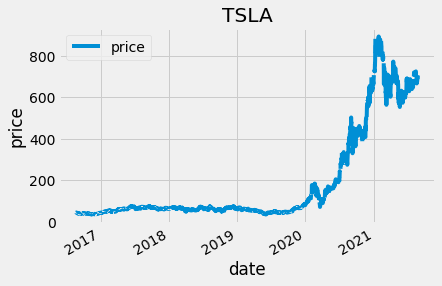

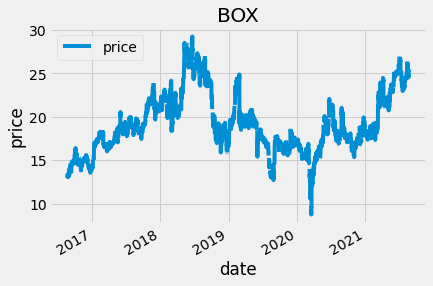

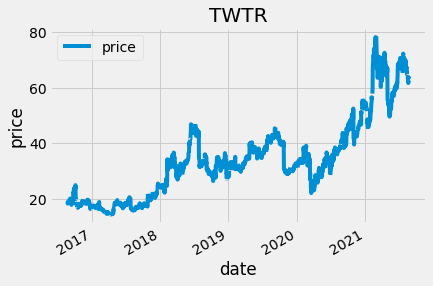

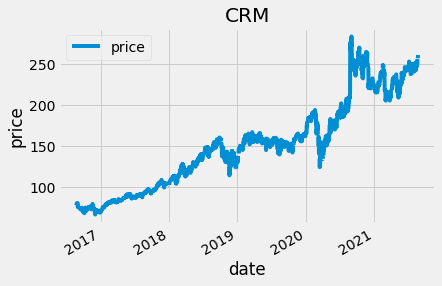

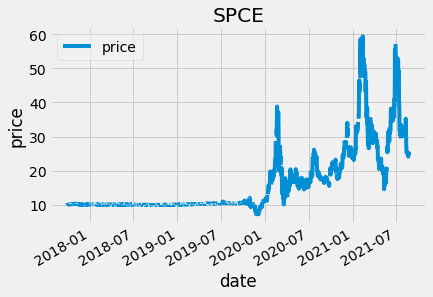

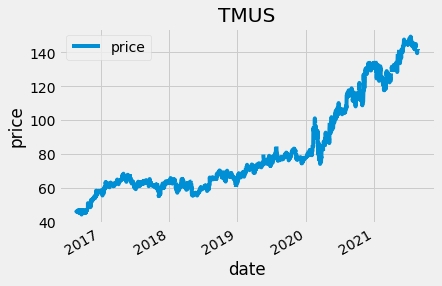

In [861]:
for stock in stocks:
    stocks[stock].plot()
    plt.xlabel('date', color='black')
    plt.ylabel('price', color='black')
    plt.title(stock, color='black')
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.savefig('./figures/data_wrangling/stocks_{}.png'.format(stock), bbox_inches='tight', tranparent=True)
    plt.show()
    
    

In [862]:
for stock in stocks:
    print(stocks[stock].isna().any().sum())

1
1
1
1
1
1


All of the stocks have the same number of values with the exception of Virgin Galactic, which has been on the NYSE for less than the 5 year max alloted by yfinance. No missing numbers are detected.

### De-trending the time series stock data 

We will use the percent change in the stock prices as a target that we will later bin into categories.  

In [863]:
for stock in stocks:
    stocks[stock]['percent change'] = stocks[stock]['price'].pct_change()
    stocks[stock].fillna(0, inplace=True)

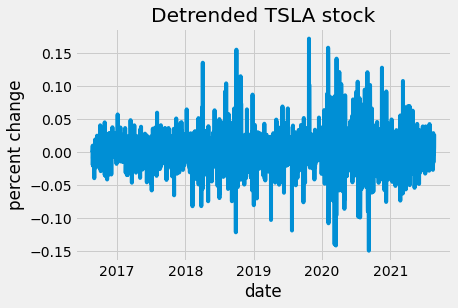

In [864]:
_ = plt.plot(stocks['TSLA'][['percent change']])
_ = plt.xlabel('date')
_ = plt.ylabel('percent change')
_ = plt.title('Detrended TSLA stock')
plt.savefig('./figures/data_wrangling/detrended_stock.png', bbox_inches='tight')

In [865]:
# convert to dataframe and save for later
stocks_full = pd.DataFrame()
for stock in stocks:
    # get stock ticker for grouping
    stocks[stock]['ticker'] = stock
    stocks_full = stocks_full.append(stocks[stock])

# pickle and save
stocks_full = stocks_full.reset_index()
pd.to_pickle(stocks_full, './data/stocks_full_df.pkl')

In [866]:

stocks_full

,date,price,percent change,ticker
0,2016-08-23 09:30:00,44.863998,0.000000,TSLA
1,2016-08-23 16:00:00,44.967999,0.002318,TSLA
2,2016-08-24 09:30:00,45.410000,0.009829,TSLA
3,2016-08-24 16:00:00,44.523998,-0.019511,TSLA
4,2016-08-25 09:30:00,44.622002,0.002201,TSLA
...,...,...,...,...
21115,2021-08-21 16:00:00,0.000000,0.000000,TMUS
21116,2021-08-22 09:30:00,0.000000,0.000000,TMUS
21117,2021-08-22 16:00:00,0.000000,0.000000,TMUS
21118,2021-08-23 09:30:00,141.509995,-0.002116,TMUS


## 1.2.5 Collecting the tweets <a id='1.2.5_Collecting_Tweet'></a>
We will collect the CEOs tweets over the same time-span as the collected stocks

In [867]:
# Get the tweets from the CEOs of the companies
# Get user_ids in case of name changes. 

        
handles_tickers = {'elonmusk':'TSLA', 'levie':'BOX','jack':'TWTR', 'Benioff':'CRM', 
            'richardbranson':'SPCE', 'JohnLegere':'TMUS'}

In [868]:
start_date = {}
for user in user_stocks:
    start_date[user] = dt.strftime(stocks[user_stocks[user]].reset_index().date.min(), '%Y-%m-%d %H:%M:%S')

In [869]:
usernames = list(user_stocks.keys())

In [870]:
#%%time

# Uncomment to collect recent tweets (NOTE: Twint is currently not working as expected at this time)
#ceos = []
#for user in usernames:
#    c = twint.Config()
#    c.Username = user
#    c.User_full = True
#    c.Count = True
#    c.Stats = True
#    c.Pandas = True
#    c.Store_pandas = True
#    c.Hide_output = True
#    c.Pandas_clean = True
#    c.Since = start_date[user]

    # run search
#    twint.run.Search(c)

# extract columns and save dataframe in list
#columns = twint.output.panda.Tweets_df.columns
#ceo = twint.output.panda.Tweets_df[columns]
#ceos.append(ceo)

# Read in last saved file
ceos = pd.read_pickle('./data/ceos.pkl')
usernames = ['elonmusk', 'levie', 'jack', 'Benioff','richardbranson', 'JohnLegere']

In [871]:
ceos.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,search
0,1417453075892080641,1417427520266268677,2021-07-20 07:55:22 EDT,2021-07-20,07:55:22,-0400,44196397,elonmusk,Elon Musk,,...,,,,,"[{'screen_name': 'vincent13031925', 'name': 'V...",,,,,None
1,1417390555001098246,1417251070989029376,2021-07-20 03:46:56 EDT,2021-07-20,03:46:56,-0400,44196397,elonmusk,Elon Musk,,...,,,,,"[{'screen_name': 'blueorigin', 'name': 'Blue O...",,,,,None
2,1417293886897098762,1417278493428264963,2021-07-19 21:22:49 EDT,2021-07-19,21:22:49,-0400,44196397,elonmusk,Elon Musk,,...,,,,,"[{'screen_name': 'SpacePadreIsle', 'name': 'SP...",,,,,None
3,1417277335863140363,1417277092090191884,2021-07-19 20:17:03 EDT,2021-07-19,20:17:03,-0400,44196397,elonmusk,Elon Musk,,...,,,,,"[{'screen_name': 'TLPN_Official', 'name': 'The...",,,,,None
4,1417274819461095432,1417274819461095432,2021-07-19 20:07:03 EDT,2021-07-19,20:07:03,-0400,44196397,elonmusk,Elon Musk,,...,,,,,[],,,,,None


In [872]:
stocks_full.head()

,date,price,percent change,ticker
0,2016-08-23 09:30:00,44.863998,0.000000,TSLA
1,2016-08-23 16:00:00,44.967999,0.002318,TSLA
2,2016-08-24 09:30:00,45.410000,0.009829,TSLA
3,2016-08-24 16:00:00,44.523998,-0.019511,TSLA
4,2016-08-25 09:30:00,44.622002,0.002201,TSLA


In [873]:
stocks_full

,date,price,percent change,ticker
0,2016-08-23 09:30:00,44.863998,0.000000,TSLA
1,2016-08-23 16:00:00,44.967999,0.002318,TSLA
2,2016-08-24 09:30:00,45.410000,0.009829,TSLA
3,2016-08-24 16:00:00,44.523998,-0.019511,TSLA
4,2016-08-25 09:30:00,44.622002,0.002201,TSLA
...,...,...,...,...
21115,2021-08-21 16:00:00,0.000000,0.000000,TMUS
21116,2021-08-22 09:30:00,0.000000,0.000000,TMUS
21117,2021-08-22 16:00:00,0.000000,0.000000,TMUS
21118,2021-08-23 09:30:00,141.509995,-0.002116,TMUS


In [874]:
ceos_merged = combine_tweets(ceos)
wrangled_df = combine_tweets_stocks(ceos_merged, stocks_full)

In [875]:
sample_tweets = ' '.join(wrangled_df['tweet'].sample(frac=1))[:10000]
sample_tweets

"Whoa! Amazing technology. Can’t wait to see this in more places!  https://t.co/jefz2tl3jv Made a gingerbread house with my daughter and left her alone to add the name ;)  https://t.co/dYrcuskhIZ Apparently it’s not easy bein’ the big guy 🎅🏻 https://t.co/buej9xh6SB Here come the celebrations! Happy Hanukkah &amp; Merry Christmas Eve to everyone!!  https://t.co/6Fwjsldbd0 If this doesn’t put you in the holiday spirit, I don’t know what will! PS - nice moves, @braxtoncarter, @sievertmike and @nevilleray!  https://t.co/iHqaZqRf8j @TamiPooler email me. John.Legere@t-mobile.com Merry Christmas Eve!!!  https://t.co/c30KNJzTLe First #SuperMario, now more?!? #yes!  https://t.co/RLmqWVsxSd “We know a lot about how to end homelessness, but that knowledge doesnt always reach policymakers and is often not properly targeted,” said \u2066@MKushel\u2069. “We have far more to learn about designing the most effective ways to prevent &amp; end homelessness.”  https://t.co/MHVHWhT1Ez I’m very Proud of Th

# Text Analysis/Cleaning/and Preprocessing

In [843]:
# regex patterns
import re
import html 
import demoji
from collections import Counter
import spacy
nlp = spacy.load('en_core_web_md')
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import contractions

demoji.download_codes()
EMAIL_PATTERN = r'[A-Za-z0-9]+[@]+[^\s]+'
MENTION_PATTERN = r'[@]+[^\s]+'
HASHTAG_PATTERN = r'[#]\S+'
LINK_PATTERN = r'https?:\S+'
CASHTAG_PATTERN = r'[$][A-Z]+'
EMOJIS_PATTERN = r'((:\))|(;\)))'

stop_words = []

# https://stackoverflow.com/questions/43018030/replace-apostrophe-short-words-in-python


STOP_WORDS = STOP_WORDS.union(set(['s', 'it', 'm', 'you', 're', 'it ', ' s', 's ', 'i', 't']))

In [849]:
!pip install -U normalize

     |████████████████████████████████| 103 kB 3.0 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [852]:


def clean_tweets(sample_tweets):
    """
    add normalize, do some exploring to see if any abbreviations need to be used
    https://towardsdatascience.com/text-preprocessing-steps-and-universal-pipeline-94233cb6725a
    """
    new_sample_tweets = html.unescape(sample_tweets)
    new_sample_tweets = ' '.join(re.sub(EMAIL_PATTERN, ' ', new_sample_tweets).split())
    new_sample_tweets = ' '.join(re.sub(MENTION_PATTERN, ' ', new_sample_tweets).split())
    new_sample_tweets = ' '.join(re.sub(HASHTAG_PATTERN, ' ', new_sample_tweets).split())
    new_sample_tweets = ' '.join(re.sub(CASHTAG_PATTERN, ' ', new_sample_tweets).split())
    new_sample_tweets = ' '.join(re.sub(LINK_PATTERN, ' ', new_sample_tweets).split())
    new_sample_tweets = ' '.join(re.sub(r'(w/)', 'with ', new_sample_tweets).split())
    new_sample_tweets = demoji.replace(new_sample_tweets, repl=' ')
    new_sample_tweets = ' '.join(re.sub(r'((:\)))', 'smiling face', new_sample_tweets).split())
    new_sample_tweets = ' '.join(re.sub(r'((;\)))', 'winking face', new_sample_tweets).split())
    new_sample_tweets = new_sample_tweets.lower()
    new_sample_tweets = new_sample_tweets.replace('/', '')
    new_sample_tweets = new_sample_tweets.replace('\\', '')
    new_sample_tweets = ' '.join([contractions.fix(word) for word in new_sample_tweets.split()])
    new_sample_tweets = ' '.join(re.sub(r'[^a-z]', ' ', new_sample_tweets).split())
    new_sample_tweets = PorterStemmer().stem(new_sample_tweets) # fix this
    new_sample_tweets = WordNetLemmatizer().lemmatize(new_sample_tweets) # fix this
    new_sample_tweets = ' '.join([word for word in new_sample_tweets.split() if len(word) >2 ])
    new_sample_tweets = ' '.join([word for word in new_sample_tweets.split() if word not in STOP_WORDS]) # Go through this
    return new_sample_tweets

def engineer_tweet_features(wrangled_df, method='count'):
    """
    Takes in raw tweet and extracts mentions, hashtags, links,
    (currently only counts, will look into scikit learn before implementing my own code for future transformations)
    """
    
    
    wrangled_df[['emails', 'links', 'mentions', 'hashtags', 'emojis']] = 0
    features_df = wrangled_df[['emails', 'links', 'mentions', 'hashtags', 'emojis']] 
    features_df['emails'] = wrangled_df['tweet'].apply(lambda x: re.findall(EMAIL_PATTERN, x)).apply(lambda x: len(x))
    features_df['links'] = wrangled_df['tweet'].apply(lambda x: re.findall(LINK_PATTERN, x)).apply(lambda x: len(x))
    features_df['mentions'] = wrangled_df['tweet'].apply(lambda x: re.findall(MENTION_PATTERN, x)).apply(lambda x: len(x))
    features_df['hashtags'] = wrangled_df['tweet'].apply(lambda x: re.findall(HASHTAG_PATTERN, x)).apply(lambda x: len(x))
    features_df['emojis'] = wrangled_df['tweet'].apply(lambda x: demoji.findall_list(x)).apply(lambda x: len(x))
    return features_df

import numpy as np
import multiprocessing as mp

import string
import spacy 
import en_core_web_sm
from nltk.tokenize import word_tokenize
from sklearn.base import TransformerMixin, BaseEstimator
import normalize

nlp = en_core_web_sm.load()

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 variety="BrE",
                 user_abbrevs={},
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Text normalization
            2. Punctuation removal
            3. Stop words removal
            4. Lemmatization
        
        variety - format of date (AmE - american type, BrE - british format) 
        user_abbrevs - dict of user abbreviations mappings (from normalise package)
        n_jobs - parallel jobs to run
        """
        self.username = userna,e
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        normalized_text = self._normalize(text)
        doc = nlp(normalized_text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

    def _normalize(self, text):
        # some issues in normalise package
        try:
            return ' '.join(normalise(text, variety=self.variety, user_abbrevs=self.user_abbrevs, verbose=False))
        except:
            return text

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]

    def _lemmatize(self, doc):
        return ' '.join([t.lemma_ for t in doc])

In [845]:
%%time

# clean up and add counts of twitter tags
wrangled_df['cleaned'] = wrangled_df['tweet']
wrangled_df['cleaned'] = wrangled_df['tweet'].apply(lambda x: clean_tweets(x))
wrangled_df[['emails', 'links', 'mentions', 'hashtags', 'emojis']] = engineer_tweet_features(wrangled_df)

CPU times: user 1min 4s, sys: 953 ms, total: 1min 5s
Wall time: 1min 9s


In [853]:
# Do NMF

In [846]:
wrangled_df

,username,tweet,date,number of tweets,price,percent change,ticker,cleaned,emails,links,mentions,hashtags,emojis
0,elonmusk,@vincent13031925 Great to hear! @blueorigin B...,2021-07-20 09:30:00,5,651.989990,0.008929,TSLA,great hear best luck tomorrow haha depending p...,0,0,6,0,0
1,elonmusk,"@jack @BitcoinMagazine @CathieDWood Sure, I ha...",2021-07-19 16:00:00,2,646.219971,0.025925,TSLA,sure ton talk sing cover final countdown europ,0,1,6,0,0
2,elonmusk,@DragTimes @Tesla Nice @grimnut @Tesla @WholeM...,2021-07-19 09:30:00,3,629.890015,-0.022244,TSLA,nice haha need touch shifter new auto detect d...,0,0,7,0,0
3,elonmusk,"@thePiggsBoson Problem 1st, theory 2nd is for ...",2021-07-18 16:00:00,1,0.000000,0.000000,TSLA,problem theory sure way establishes relevance ...,0,0,1,0,0
4,elonmusk,Cybrrrtruck https://t.co/rdiMFdYOS6 @Artifact...,2021-07-18 09:30:00,6,0.000000,0.000000,TSLA,cybrrrtruck time hodl champion hipster pohtayt...,0,1,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3348,JohnLegere,@MillerPhelan Thank you!! @LIVEWlRED You shoul...,2016-08-25 09:30:00,8,46.310001,0.002164,TMUS,thank welcome winking face switch smiling face...,0,1,12,1,1
3349,JohnLegere,"Sunscreen doesn’t smell great, but I don’t thi...",2016-08-24 16:00:00,4,46.209999,-0.009644,TMUS,sunscreen smell great think fried chicken scen...,0,4,1,0,1
3350,JohnLegere,@Woofdah @TMobile What are you going to rent?!...,2016-08-24 09:30:00,15,46.660000,-0.003630,TMUS,going rent best day week switch good choice th...,0,7,16,4,1
3351,JohnLegere,@silods yes! Very proud of @UMassAmherst and t...,2016-08-23 16:00:00,7,46.830002,-0.002768,TMUS,yes proud studied possibly smiling face hilari...,0,4,5,5,0


In [819]:
wrangled_df[['emails', 'links', 'mentions', 'hashtags', 'emojis']] = features_df

In [820]:
wrangled_df

,username,tweet,date,number of tweets,price,percent change,ticker,cleaned,emails,links,mentions,hashtags,emojis
0,elonmusk,@vincent13031925 Great to hear! @blueorigin B...,2021-07-20 09:30:00,5,651.989990,0.008929,TSLA,great hear best luck tomorrow haha depending p...,0,0,6,0,0
1,elonmusk,"@jack @BitcoinMagazine @CathieDWood Sure, I ha...",2021-07-19 16:00:00,2,646.219971,0.025925,TSLA,sure ton talk sing cover final countdown europ,0,1,6,0,0
2,elonmusk,@DragTimes @Tesla Nice @grimnut @Tesla @WholeM...,2021-07-19 09:30:00,3,629.890015,-0.022244,TSLA,nice haha need touch shifter new auto detect d...,0,0,7,0,0
3,elonmusk,"@thePiggsBoson Problem 1st, theory 2nd is for ...",2021-07-18 16:00:00,1,0.000000,0.000000,TSLA,problem theory sure way establishes relevance ...,0,0,1,0,0
4,elonmusk,Cybrrrtruck https://t.co/rdiMFdYOS6 @Artifact...,2021-07-18 09:30:00,6,0.000000,0.000000,TSLA,cybrrrtruck time hodl champion hipster pohtayt...,0,1,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3348,JohnLegere,@MillerPhelan Thank you!! @LIVEWlRED You shoul...,2016-08-25 09:30:00,8,46.310001,0.002164,TMUS,thank welcome winking face switch smiling face...,0,1,12,1,1
3349,JohnLegere,"Sunscreen doesn’t smell great, but I don’t thi...",2016-08-24 16:00:00,4,46.209999,-0.009644,TMUS,sunscreen smell great think fried chicken scen...,0,4,1,0,1
3350,JohnLegere,@Woofdah @TMobile What are you going to rent?!...,2016-08-24 09:30:00,15,46.660000,-0.003630,TMUS,going rent best day week switch good choice th...,0,7,16,4,1
3351,JohnLegere,@silods yes! Very proud of @UMassAmherst and t...,2016-08-23 16:00:00,7,46.830002,-0.002768,TMUS,yes proud studied possibly smiling face hilari...,0,4,5,5,0


In [809]:
%%time
# currently testing these features out as counts, but adding them (some/all) into the nlp pipeline when later developed
wrangled_df[['emails', 'links', 'mentions', 'hashtags', 'emojis']] = 0

wrangled_df['emails'] = wrangled_df['tweet'].apply(lambda x: re.findall(EMAIL_PATTERN, x)).apply(lambda x: len(x))
wrangled_df['links'] = wrangled_df['tweet'].apply(lambda x: re.findall(LINK_PATTERN, x)).apply(lambda x: len(x))
wrangled_df['mentions'] = wrangled_df['tweet'].apply(lambda x: re.findall(MENTION_PATTERN, x)).apply(lambda x: len(x))
wrangled_df['hashtags'] = wrangled_df['tweet'].apply(lambda x: re.findall(HASHTAG_PATTERN, x)).apply(lambda x: len(x))
wrangled_df['emojis'] = wrangled_df['tweet'].apply(lambda x: demoji.findall_list(x)).apply(lambda x: len(x))

CPU times: user 34.7 s, sys: 423 ms, total: 35.1 s
Wall time: 36.8 s


In [810]:
wrangled_df

,username,tweet,date,number of tweets,price,percent change,ticker,cleaned,emails,links,mentions,hashtags,emojis
0,elonmusk,@vincent13031925 Great to hear! @blueorigin B...,2021-07-20 09:30:00,5,651.989990,0.008929,TSLA,great hear best luck tomorrow haha depending p...,0,0,6,0,0
1,elonmusk,"@jack @BitcoinMagazine @CathieDWood Sure, I ha...",2021-07-19 16:00:00,2,646.219971,0.025925,TSLA,sure ton talk sing cover final countdown europ,0,1,6,0,0
2,elonmusk,@DragTimes @Tesla Nice @grimnut @Tesla @WholeM...,2021-07-19 09:30:00,3,629.890015,-0.022244,TSLA,nice haha need touch shifter new auto detect d...,0,0,7,0,0
3,elonmusk,"@thePiggsBoson Problem 1st, theory 2nd is for ...",2021-07-18 16:00:00,1,0.000000,0.000000,TSLA,problem theory sure way establishes relevance ...,0,0,1,0,0
4,elonmusk,Cybrrrtruck https://t.co/rdiMFdYOS6 @Artifact...,2021-07-18 09:30:00,6,0.000000,0.000000,TSLA,cybrrrtruck time hodl champion hipster pohtayt...,0,1,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3348,JohnLegere,@MillerPhelan Thank you!! @LIVEWlRED You shoul...,2016-08-25 09:30:00,8,46.310001,0.002164,TMUS,thank welcome winking face switch smiling face...,0,1,12,1,1
3349,JohnLegere,"Sunscreen doesn’t smell great, but I don’t thi...",2016-08-24 16:00:00,4,46.209999,-0.009644,TMUS,sunscreen smell great think fried chicken scen...,0,4,1,0,1
3350,JohnLegere,@Woofdah @TMobile What are you going to rent?!...,2016-08-24 09:30:00,15,46.660000,-0.003630,TMUS,going rent best day week switch good choice th...,0,7,16,4,1
3351,JohnLegere,@silods yes! Very proud of @UMassAmherst and t...,2016-08-23 16:00:00,7,46.830002,-0.002768,TMUS,yes proud studied possibly smiling face hilari...,0,4,5,5,0


In [791]:
wrangled_df['emojis'].max()

'🪑 ☃️'

'great fucks apparently hillary considered tim cook bill gates potential vps supporting mac bipartisan quotes challenge way think diana touched hearts people makes happy legacy continue day pivotal moment important initiative thanks great day style input brilliant outcome congratulations winner thanks olawale glad hear enjoying seeing story princess diana jumper brought wonderful memories march starship launch tomorrow window opens yes beta offered widely version hopefully month fsd beta build normally drives interventions version big step change tesla solving major real world widely known welcome good point let figure tomorrow exciting video coverage place festooned cameras heard fix situation fan video sounds right want careful transition period surprisingly high usage horses trend obvious space mars stars area larger boca chica leader shall doge ready come sorry hear feel free email smiling face john great hear thanks dude thumbs yes email john definitely switch omg amazing face tea

CPU times: user 30.1 s, sys: 475 ms, total: 30.6 s
Wall time: 33.2 s


In [760]:
wrangled_df.head()

,username,tweet,date,number of tweets,price,percent change,ticker,cleaned
0,elonmusk,@vincent13031925 Great to hear! @blueorigin B...,2021-07-20 09:30:00,5,651.989990,0.008929,TSLA,great hear best luck tomorrow haha depending p...
1,elonmusk,"@jack @BitcoinMagazine @CathieDWood Sure, I ha...",2021-07-19 16:00:00,2,646.219971,0.025925,TSLA,sure ton talk sing cover final countdown europ
2,elonmusk,@DragTimes @Tesla Nice @grimnut @Tesla @WholeM...,2021-07-19 09:30:00,3,629.890015,-0.022244,TSLA,nice haha need touch shifter new auto detect d...
3,elonmusk,"@thePiggsBoson Problem 1st, theory 2nd is for ...",2021-07-18 16:00:00,1,0.000000,0.000000,TSLA,problem theory sure way establishes relevance ...
4,elonmusk,Cybrrrtruck https://t.co/rdiMFdYOS6 @Artifact...,2021-07-18 09:30:00,6,0.000000,0.000000,TSLA,cybrrrtruck time hodl champion hipster pohtayt...


In [690]:
pd.DataFrame(new_sample_tweets.split()).value_counts()

s           14
i            7
t            6
face         6
it           5
            ..
haha         1
habitats     1
green        1
grand        1
yum          1
Length: 525, dtype: int64

In [603]:
stop_words += [most_common[i][0] for i in range(len(most_common))]

In [621]:
stop_words += ['not', 'up', 'we', 'pls', 'm', 'an', 'if', 'do']

In [622]:
new_sample_tweets = ' '.join([w for w in new_sample_tweets.split() if w not in stop_words])

In [623]:
new_sample_tweets

'love display heathrow generally everything works turn off back again resetting rebooting ourselves some rest relaxation interacting other people exercising always good idea redressing gender imbalance art world small things make big difference innovating every area their launch process launch small satellite revolution governments other key players been treading water far too long time get serious about protecting ocean after millions years stability co ocean causing acidify times faster any other time human history coming soon gunna lie sleight going my future watch list anything gadgets thumbs time year save spend or donate money bag wrapped gift can help email party popper went last night took some selfies time was snowflakeprincess reindeer yes am waiting let here joke grinning face grinning face grinning face omg amazing email re never too young super mario right winking face am easy please early saturday morning email help look into welcome t mobile help email look into anything

In [460]:
all_words = set(new_sample_tweets.split())
word_freq = {}
for word in new_sample_tweets.split():
    if word in word_freq.keys():
        word_freq[word] += 1
    else:
        word_freq[word] = 1

In [474]:
np.array(word_freq.values())

array(dict_values([3, 10, 3, 1, 7, 17, 1, 15, 2, 1, 3, 2, 1, 54, 1, 4, 14, 1, 4, 1, 17, 1, 1, 1, 5, 4, 21, 8, 24, 7, 51, 3, 3, 3, 3, 5, 11, 20, 3, 3, 1, 1, 1, 1, 1, 4, 1, 2, 9, 8, 2, 1, 1, 1, 9, 3, 30, 2, 3, 13, 2, 1, 14, 2, 1, 1, 1, 1, 7, 7, 1, 1, 24, 1, 4, 1, 14, 1, 1, 1, 1, 1, 5, 1, 3, 3, 21, 13, 1, 1, 4, 11, 2, 2, 5, 5, 6, 2, 1, 3, 4, 1, 2, 2, 1, 3, 1, 1, 1, 4, 2, 2, 1, 2, 1, 2, 5, 1, 1, 2, 2, 1, 1, 7, 1, 4, 1, 1, 1, 1, 2, 2, 4, 4, 1, 5, 5, 1, 1, 1, 3, 6, 8, 1, 4, 1, 11, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 2, 3, 4, 2, 1, 8, 1, 3, 1, 1, 1, 1, 1, 14, 4, 1, 1, 3, 1, 9, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 5, 1, 1, 1, 1, 3, 3, 1, 2, 1, 1, 2, 1, 1, 1, 3, 1, 6, 1, 1, 5, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 4, 1, 6, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 4, 1, 1, 1, 1, 1, 2, 1, 3, 5, 1, 2, 1, 1, 2, 2, 4, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 

In [369]:
stripped_tweets = sample_tweets.join(re.sub())

# mentions (@)
# hashtags(#)
# urls
# encoding
# emojis
# punctuation

'The @AmnestyUK #FamiliesTogether campaign is calling for the easing of restrictive UK rules to help reunite refugees with their families. Join @VirginExp and support the campaign today:  https://t.co/KUUU4oUYSu  https://t.co/isqptgvedb The @VirginHotels approach to creating a thriving community  https://t.co/AYNjGDc5b3  https://t.co/UAXx5Z97IO Doing your to-do lists  https://t.co/rwvV8ZRc9z  https://t.co/mGQaPOGNN9 @paul_tiskiy @TMobile @SamsungMobileUS BOTH!! You had me at Chocolate. 😋 https://t.co/aSe4GfWcpY Awesome! This is a long time coming. #IamBatman  https://t.co/J4vfb52glW @lloyd_robson   https://t.co/JngjLltcXe Setting your biz up w/@TMobile is the way to go! America’s Best Unlimited Network + @MarcusLemonis mobile tech #ProTips = pure genius!  https://t.co/D645b4PsNy @rparenteaujr @verizon @TMobile we can\'t wait to have you! @lettinggo45 How do I choose just ONE?! @TerpSaint John.Legere@t-mobile.com @jerome_parra86 If only it was in magenta ;) @mixmastarob @TMobile They st

In [370]:
import html
html.unescape(sample_tweets)

'The @AmnestyUK #FamiliesTogether campaign is calling for the easing of restrictive UK rules to help reunite refugees with their families. Join @VirginExp and support the campaign today:  https://t.co/KUUU4oUYSu  https://t.co/isqptgvedb The @VirginHotels approach to creating a thriving community  https://t.co/AYNjGDc5b3  https://t.co/UAXx5Z97IO Doing your to-do lists  https://t.co/rwvV8ZRc9z  https://t.co/mGQaPOGNN9 @paul_tiskiy @TMobile @SamsungMobileUS BOTH!! You had me at Chocolate. 😋 https://t.co/aSe4GfWcpY Awesome! This is a long time coming. #IamBatman  https://t.co/J4vfb52glW @lloyd_robson   https://t.co/JngjLltcXe Setting your biz up w/@TMobile is the way to go! America’s Best Unlimited Network + @MarcusLemonis mobile tech #ProTips = pure genius!  https://t.co/D645b4PsNy @rparenteaujr @verizon @TMobile we can\'t wait to have you! @lettinggo45 How do I choose just ONE?! @TerpSaint John.Legere@t-mobile.com @jerome_parra86 If only it was in magenta ;) @mixmastarob @TMobile They st

# Pipeline Testing

In [365]:
def combine_tweets(full_df):
    """
        takes in a pandas dataframe of tweets with dates and times for each created tweet, and the tweet author's handle.
        It groups all of the user's tweets that occured between opening (9:30:00 EST) and closing (16:00:00 EST) stock times for open stock days, and returns a dataframe of the grouped tweets and the number of tweets
        that were collected for that time frame.
        A tweet is grouped via the following criteria:
        - If tweet is earlier than 9:30, it applies to that price (opening) on the same date. 
        - It tweet is after 9:30, but before 16:00 (closing), it applies to the following price on the same date.
        - If tweet is after 16:00, it applies to the next opening date.

        To Do (not in order):
        collect tweets and stocks directly 
        allow to specify period

        """
    categorical_features = ['urls', 'photos', 'hashtags', 'cashtags', 'thumbnail', 'mentions']
    text_features = ['tweet']
    timestamp_features = ['date', 'time']
    users = full_df.username.unique()
    merged_df = pd.DataFrame()
    def combine_tweets_user(df):
        username = df.username
        collected_tweets = {}
        #df['time'] = pd.to_datetime(df['time'])
        #df['number of tweets'] = 1
        # fix missing vals
        df[categorical_features] = df[categorical_features].applymap(lambda x: np.nan if len(x) == 0 else x)
        # If tweet is earlier than 9:30, it applies to that price (opening) on the same date. 

        df['time'] = pd.to_datetime(df['created_at']).dt.time
        df['date'] = pd.to_datetime(df['created_at']).dt.date

        for i in range(len(df)):
            if df['time'].iloc[i] <= dt.strptime('09:30:00', '%H:%M:%S').time():
                df['time'].iloc[i] = dt.strptime('09:30:00', '%H:%M:%S').time()

        # It tweet is after 9:30, but before 16:00 (closing), it applies to the following price on the same date.

            if (df['time'].iloc[i] > dt.strptime('09:30:00', '%H:%M:%S').time()) and (df['time'].iloc[i] <= dt.strptime('16:00:00', '%H:%M:%S').time()):
                df['time'].iloc[i] = dt.strptime('16:00:00', '%H:%M:%S').time()

        # If tweet is after 16:00, apply it to the next opening date.
        #for i in range(len(df)):
            if df['time'].iloc[i] > dt.strptime('16:00:00', '%H:%M:%S').time():
                df['date'].iloc[i] = df['date'].iloc[i] + timedelta(days=1)
                df['time'].iloc[i] = dt.strptime('09:30:00', '%H:%M:%S').time()

        # Combine dates and times
        df['date'] = df['date'].astype(str)
        df['time'] = df['time'].astype(str)
        df['date'] = pd.to_datetime(df['date'] + ' ' + df['time'])

        tweet = ""
        df['number of tweets'] = 1
        to_merge = df.groupby('date').sum()
        #to_merge['date'] = pd.to_datetime(to_merge['date'], format='%Y-%M-%d').dt.date
        # date is dictionary key
        collected_tweets[df['date'].iloc[0]] = tweet

        for i in range(len(df.index)):
            current_date = df['date'].iloc[i]
            if current_date in collected_tweets:
                collected_tweets[current_date] += " " + str(df['tweet'].iloc[i])
            else:
                collected_tweets[current_date] = str(df['tweet'].iloc[i])

        df = pd.DataFrame.from_dict(collected_tweets, orient='index', columns = ['tweet'])
        df.reset_index(inplace=True)
        df = df.rename(columns={'index':'date'})
        df['username'] = username
        df_merged = pd.merge(df, to_merge.reset_index(), on='date')

        return df_merged
    for user in users:
        merged_df = merged_df.append(combine_tweets_user(full_df[full_df['username'] == user]))
    return merged_df[['username', 'tweet', 'date', 'number of tweets']]
    
def combine_tweets_stocks(ceos_merged, stocks_full):
    new_df = pd.DataFrame()
    for user in ceos_merged['username'].unique():
        ticker = handles_tickers[user]
        tweet_df = ceos_merged[ceos_merged['username'] == user]
        stock_df = stocks_full[stocks_full['ticker'] == ticker]
        new_df = new_df.append(tweet_df.merge(stock_df, how='left', on='date')).dropna(subset=['ticker'])  
    return new_df

In [260]:
%%time
# test
ceos_merged = combine_tweets(ceos)

CPU times: user 2min 15s, sys: 2.45 s, total: 2min 17s
Wall time: 2min 26s


In [261]:
ts = ceos_merged['date'].dt.time

In [262]:
ts.value_counts()

09:30:00    6567
16:00:00    5397
Name: date, dtype: int64

In [263]:
ceos_merged

,username,tweet,date,number of tweets
0,elonmusk,@vincent13031925 Great to hear! @blueorigin B...,2021-07-20 09:30:00,5
1,elonmusk,"@jack @BitcoinMagazine @CathieDWood Sure, I ha...",2021-07-19 16:00:00,2
2,elonmusk,@DragTimes @Tesla Nice @grimnut @Tesla @WholeM...,2021-07-19 09:30:00,3
3,elonmusk,"@thePiggsBoson Problem 1st, theory 2nd is for ...",2021-07-18 16:00:00,1
4,elonmusk,Cybrrrtruck https://t.co/rdiMFdYOS6 @Artifact...,2021-07-18 09:30:00,6
...,...,...,...,...
3412,JohnLegere,"No such thing at @TMobile, but I’m all for a l...",2016-07-22 16:00:00,6
3413,JohnLegere,Good to know for #SlowCookerSunday! https://t...,2016-07-22 09:30:00,18
3414,JohnLegere,Batman had to make an appearance in #SuicideSq...,2016-07-21 16:00:00,6
3415,JohnLegere,.@TMobile customers are getting unlimited high...,2016-07-21 09:30:00,16


In [272]:
stocks_full

,date,price,percent change,ticker
0,2016-08-23 09:30:00,44.863998,0.000000,TSLA
1,2016-08-23 16:00:00,44.967999,0.002318,TSLA
2,2016-08-24 09:30:00,45.410000,0.009829,TSLA
3,2016-08-24 16:00:00,44.523998,-0.019511,TSLA
4,2016-08-25 09:30:00,44.622002,0.002201,TSLA
...,...,...,...,...
21115,2021-08-21 16:00:00,0.000000,0.000000,TMUS
21116,2021-08-22 09:30:00,0.000000,0.000000,TMUS
21117,2021-08-22 16:00:00,0.000000,0.000000,TMUS
21118,2021-08-23 09:30:00,141.509995,-0.002116,TMUS


In [277]:
ceos_merged['username'].unique()

array(['elonmusk', 'levie', 'jack', 'Benioff', 'richardbranson',
       'JohnLegere'], dtype=object)

In [289]:
new_df = pd.DataFrame()
for user in ceos_merged['username'].unique():
    ticker = handles_tickers[user]
    tweet_df = ceos_merged[ceos_merged['username'] == user]
    stock_df = stocks_full[stocks_full['ticker'] == ticker]
    new_df = new_df.append(tweet_df.merge(stock_df, how='left', on='date'))
    new_df = new_df.dropna(subset=['ticker'])

In [290]:
new_df

,username,tweet,date,number of tweets,price,percent change,ticker
0,elonmusk,@vincent13031925 Great to hear! @blueorigin B...,2021-07-20 09:30:00,5,651.989990,0.008929,TSLA
1,elonmusk,"@jack @BitcoinMagazine @CathieDWood Sure, I ha...",2021-07-19 16:00:00,2,646.219971,0.025925,TSLA
2,elonmusk,@DragTimes @Tesla Nice @grimnut @Tesla @WholeM...,2021-07-19 09:30:00,3,629.890015,-0.022244,TSLA
3,elonmusk,"@thePiggsBoson Problem 1st, theory 2nd is for ...",2021-07-18 16:00:00,1,0.000000,0.000000,TSLA
4,elonmusk,Cybrrrtruck https://t.co/rdiMFdYOS6 @Artifact...,2021-07-18 09:30:00,6,0.000000,0.000000,TSLA
...,...,...,...,...,...,...,...
3348,JohnLegere,@MillerPhelan Thank you!! @LIVEWlRED You shoul...,2016-08-25 09:30:00,8,46.310001,0.002164,TMUS
3349,JohnLegere,"Sunscreen doesn’t smell great, but I don’t thi...",2016-08-24 16:00:00,4,46.209999,-0.009644,TMUS
3350,JohnLegere,@Woofdah @TMobile What are you going to rent?!...,2016-08-24 09:30:00,15,46.660000,-0.003630,TMUS
3351,JohnLegere,@silods yes! Very proud of @UMassAmherst and t...,2016-08-23 16:00:00,7,46.830002,-0.002768,TMUS


AttributeError: 'DataFrameGroupBy' object has no attribute 'isna'

In [52]:
CEOS_list = list(CEOS.keys())
stocks_list = list(stocks.keys())

In [53]:
for i in range(len(CEOS_list)):
    CEOS[CEOS_list[i]] = CEOS[CEOS_list[i]].merge(stocks[stocks_list[i]], how='left', on='date')
    CEOS[CEOS_list[i]] = CEOS[CEOS_list[i]].sort_values(by = 'date').reset_index(drop=True)

In [163]:


object_features = ceos.dtypes[ceos.dtypes == 'object'].index

Index(['id', 'conversation_id', 'created_at', 'time', 'timezone', 'username',
       'name', 'place', 'tweet', 'language', 'mentions', 'urls', 'photos',
       'hashtags', 'cashtags', 'link', 'quote_url', 'thumbnail', 'near', 'geo',
       'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date', 'translate', 'trans_src', 'trans_dest', 'search'],
      dtype='object')

In [145]:
musk_merged

,date,tweet,username,user_id,replies_count,retweets_count,likes_count,retweet,video,number of tweets
0,2021-07-20 09:30:00,@vincent13031925 Great to hear! @blueorigin B...,elonmusk,220981985,7458,7515,152876,0,0,5
1,2021-07-19 16:00:00,"@jack @BitcoinMagazine @CathieDWood Sure, I ha...",elonmusk,88392794,1953,1477,22616,0,0,2
2,2021-07-19 09:30:00,@DragTimes @Tesla Nice @grimnut @Tesla @WholeM...,elonmusk,132589191,1891,1368,48362,0,0,3
3,2021-07-18 16:00:00,"@thePiggsBoson Problem 1st, theory 2nd is for ...",elonmusk,44196397,475,252,2873,0,0,1
4,2021-07-18 09:30:00,Cybrrrtruck https://t.co/rdiMFdYOS6 @Artifact...,elonmusk,265178382,19035,24584,297773,0,1,6
...,...,...,...,...,...,...,...,...,...,...
2195,2016-07-25 16:00:00,@ID_AA_Carmack Maybe as a future optimization....,elonmusk,44196397,20,19,254,0,0,1
2196,2016-07-23 09:30:00,@vicentes as long as I'm alive https://t.co/K...,elonmusk,88392794,197,767,3608,0,0,2
2197,2016-07-22 09:30:00,Looking forward to the Gigafactory opening par...,elonmusk,44196397,527,1626,8910,0,0,1
2198,2016-07-21 09:30:00,Autopilot prevents serious injury or death of ...,elonmusk,309374779,1915,19947,45301,0,1,7


In [ ]:
def organize_stocks(stock): #Here

        # Instatiate Open and Close
        stock_open = stock[['date','open']]
        stock_close = stock[['date','close']]

        # Convert dates to datetime objects
        stock_open['date'] = pd.to_datetime(stock_open['date'])
        stock_close['date'] = pd.to_datetime(stock_close['date'])

        # Convert datetimes into datetime string format
        stock_open['date'] = stock_open['date'].dt.strftime('%Y-%m-%d 09:30:00')
        stock_close['date'] = stock_close['date'].dt.strftime('%Y-%m-%d 16:00:00')

        # Convert strings back into datetime objects
        stock_open['date'] = pd.to_datetime(stock_open['date'])
        stock_close['date'] = pd.to_datetime(stock_close['date'])

        # Get earliest and latest stock price dates to create a date index
        stock_open['price'] = stock_open['open']
        stock_open.drop('open', axis=1, inplace=True)

        stock_close['price'] = stock_close['close']
        stock_close.drop('close', axis=1, inplace=True)

        start_date_open = dt.strftime(stock_open.reset_index().date.min(), '%Y-%m-%d %H:%M:%S')
        end_date_open = dt.strftime(stock_open.reset_index().date.max(), '%Y-%m-%d %H:%M:%S')

        start_date_close = dt.strftime(stock_close.reset_index().date.min(), '%Y-%m-%d %H:%M:%S')
        end_date_close = dt.strftime(stock_close.reset_index().date.max(), '%Y-%m-%d %H:%M:%S')

        date_indx_open = pd.date_range(start_date_open, end_date_open).tolist()
        date_indx_close = pd.date_range(start_date_close, end_date_close).tolist()
        date_indx_open = pd.Series(date_indx_open, name='date')
        date_indx_close = pd.Series(date_indx_close, name='date')

        # Merge date index onto stock dataframes
        stock_open = pd.merge(date_indx_open, stock_open, how='left')
        stock_close = pd.merge(date_indx_close, stock_close, how='left')

        # Interpolate missing values
        stock_open['price'].interpolate(method='linear', inplace=True)
        stock_close['price'].interpolate(method='linear', inplace=True)
        
        # MAKE SURE YOU CAN UNDERSTAND THIS

        # Reset index and join open and close dataframes together
        stock_open.set_index('date', inplace=True)
        stock_close.set_index('date', inplace=True)

        stock = pd.concat([stock_open, stock_close])
        
        stock.sort_index(inplace=True)
        
        return stock

In [87]:
CEOS = {}
for user in usernames:
    CEOS[user] = ceos[ceos['username'] == user]   

In [88]:
print(len(CEOS['elonmusk']['tweet']))

11622


In [90]:
for CEO in CEOS:
# Get tweets that aren't replies
    CEOS[CEO]['reply_length'] = -1
    for i in range(len(CEOS[CEO])):
        CEOS[CEO]['reply_length'].loc[i] = len(CEOS[CEO]['reply_to'].loc[i])

    CEOS[CEO] = CEOS[CEO][CEOS[CEO]['reply_length'] == 0]
    CEOS[CEO].reset_index(drop=True, inplace=True)

In [53]:
#all_tweets = pd.DataFrame()
#for CEO in CEOS:
#    all_tweets = all_tweets.append(CEOS[CEO])
    
#all_tweets.to_pickle(f'/Users/tylerpoore/Workspace/Spring Board/Projects/Capstone_notebooks/Capstone_1_Final/data/ceos.pkl')

## Examing and Cleaning the Data 

### Examining The Tweets 

In [91]:
# Examine the scraped data

for CEO in CEOS:
    print("================")
    print(CEO)
    print("================")
    print(CEOS[CEO][['date','tweet']].head(3))

elonmusk
         date                                              tweet
0  2021-07-19  Full test duration firing of 3 Raptors on Supe...
1  2021-07-18               Cybrrrtruck  https://t.co/rdiMFdYOS6
2  2021-07-17  Fred Astaire is incredible. Worth watching his...
levie
         date                                              tweet
0  2021-07-20        This is a very sad take on entrepreneurship
1  2021-07-20  Space innovation from many ventures is just pl...
2  2021-07-20                   Amazing  https://t.co/YGDtOVvm92
jack
         date                                              tweet
0  2021-07-20  Square Banking is live! Checking, savings, deb...
1  2021-07-19                            https://t.co/Sip86oI6fU
2  2021-07-17                        ❤️  https://t.co/c4yEfiys5v
Benioff
         date                                              tweet
0  2021-05-28  Wonderful to be on @MadMoneyOnCNBC tonight ann...
1  2021-05-27  It’s happening! @Dreamforce ❤️ https://t.co/7V.

The raw twitter data has mentions, urls, emojis, and other languages besides english at first glance. 

In [56]:
# Examine the tweet columns

CEOS['elonmusk'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2967 entries, 0 to 2966
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               2967 non-null   object
 1   conversation_id  2967 non-null   object
 2   created_at       2967 non-null   object
 3   date             2967 non-null   object
 4   time             2967 non-null   object
 5   timezone         2967 non-null   object
 6   user_id          2967 non-null   int64 
 7   username         2967 non-null   object
 8   name             2967 non-null   object
 9   place            2967 non-null   object
 10  tweet            2967 non-null   object
 11  language         2967 non-null   object
 12  mentions         2967 non-null   object
 13  urls             2967 non-null   object
 14  photos           2967 non-null   object
 15  replies_count    2967 non-null   int64 
 16  retweets_count   2967 non-null   int64 
 17  likes_count      2967 non-null   

Looking at the dataframe columns entries, there are no missing values. That may be because they are using a different character than NaN, and I will look into this later. Most are of type object, but there are 4 integer columns: user_id; reply, retweet, and like counts; and video for some odd reason; and 1 boolean retweet column. All of the columns are the same type. Let's examine the columns.

In [57]:
# Look at sample integer columns

CEOS['elonmusk'].select_dtypes(include=['int']).describe()

,user_id,replies_count,retweets_count,likes_count,video,reply_length
count,2967.0,2967.000000,2967.000000,2.967000e+03,2967.000000,2967.0
mean,44196397.0,3161.311426,9051.424671,8.390999e+04,0.195147,0.0
std,0.0,7102.102366,19126.534672,1.267403e+05,0.396380,0.0
min,44196397.0,2.000000,0.000000,1.020000e+02,0.000000,0.0
25%,44196397.0,441.500000,1001.500000,1.278500e+04,0.000000,0.0
50%,44196397.0,1003.000000,2793.000000,3.468000e+04,0.000000,0.0
75%,44196397.0,2557.000000,8808.500000,9.851200e+04,0.000000,0.0
max,44196397.0,126196.000000,355536.000000,1.574723e+06,1.000000,0.0


In [60]:
# Look at first set of object columns

CEOS['elonmusk'].select_dtypes(include=['object']).describe()

,id,conversation_id,created_at,date,time,timezone,username,name,place,tweet,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,search
count,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,...,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967
unique,2967,2137,2966,1068,2895,1,1,1,1,2961,...,1,1,1,1,1,1,1,1,1,1
top,1417274819461095432,1162218267932446724,2018-04-01 18:02:31 EDT,2018-02-06,11:05:22,-0400,elonmusk,Elon Musk,,Off Twitter for a while,...,,,,,[],,,,,None
freq,1,7,2,14,2,2967,2967,2967,2967,2,...,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967


A lot of these columns I will exclude as they likely won't contribute any contributable features to predicting the stock price. I will determine the language after cleaning the tweets.

In [61]:
CEOS['elonmusk'][['tweet', 'mentions', 'urls', 'photos','hashtags', 'cashtags', 'quote_url']].describe()

,tweet,mentions,urls,photos,hashtags,cashtags,quote_url
count,2967,2967,2967,2967,2967,2967,2967
unique,2961,90,574,514,12,1,372
top,Off Twitter for a while,[],[],[],[],[],
freq,2,2806,2358,2454,2954,2967,2588


The missing values are represented by empty lists. Let's turn this into a better represenation of missing values.

Let's look at the languages first.

In [62]:
for CEO in CEOS:
    print(CEO.upper())
    print(CEOS[CEO]['language'].value_counts()[:5])

ELONMUSK
en     2613
und     246
tl       15
fr       11
de       11
Name: language, dtype: int64
LEVIE
en     1156
und      19
es        2
it        2
fr        2
Name: language, dtype: int64
JACK
en     1875
und     532
es       12
fr       11
in        9
Name: language, dtype: int64
BENIOFF
en     4288
und      48
fr       16
pt        7
es        6
Name: language, dtype: int64
RICHARDBRANSON
en     6627
und      48
fr        3
tl        3
ro        2
Name: language, dtype: int64
JOHNLEGERE
en     13853
und     2686
pt        22
es        17
fr         7
Name: language, dtype: int64


Let's see what und is

In [63]:
CEOS['elonmusk']['tweet'][CEOS['elonmusk']['language'] == 'und']

4                       https://t.co/d4ZOSKZESP
9                    🤯  https://t.co/Z11qszTY4v
22                      https://t.co/O3BGaFuMDO
24                      https://t.co/TQZ9QvcwH1
29      @WholeMarsBlog  https://t.co/ftFbmwIJz6
                         ...                   
2725                             @D1sneyNut Yes
2737                    https://t.co/3YSXZq1EVj
2745                    https://t.co/6Ve3YJoStm
2837                            @chemisdrey yes
2958                    https://t.co/Kgkz1Z3FwJ
Name: tweet, Length: 246, dtype: object

It looks like und occurs when there are a lot of mentions, links, or emojis, so I will keep this and clean them later. 

In [64]:
# Keep the en and und languages 
for CEO in CEOS:
    CEOS[CEO] = CEOS[CEO][(CEOS[CEO]['language'] == 'en') | (CEOS[CEO]['language'] == 'und')]
    CEOS[CEO].reset_index(inplace=True, drop=True)

In [65]:
for CEO in CEOS:
    print(CEO.upper())
    print(CEOS[CEO]['language'].value_counts())
    print(CEOS[CEO]['language'].value_counts().sum())

ELONMUSK
en     2613
und     246
Name: language, dtype: int64
2859
LEVIE
en     1156
und      19
Name: language, dtype: int64
1175
JACK
en     1875
und     532
Name: language, dtype: int64
2407
BENIOFF
en     4288
und      48
Name: language, dtype: int64
4336
RICHARDBRANSON
en     6627
und      48
Name: language, dtype: int64
6675
JOHNLEGERE
en     13853
und     2686
Name: language, dtype: int64
16539


### 1.3.2 Converting to Missing Values and Categorical Features <a id='1.3.2_Missing'></a>

In [66]:
for CEO in CEOS:
    print(CEO.upper())
    CEOS[CEO][['mentions', 'urls', 'photos', 'hashtags', 'cashtags', 'thumbnail']].head(3)

ELONMUSK
LEVIE
JACK
BENIOFF
RICHARDBRANSON
JOHNLEGERE


In [67]:
# Convert empty lists into NaNs for easier processing
for CEO in CEOS:
    CEOS[CEO][['mentions', 'urls', 'photos', 'hashtags', 'cashtags', 'thumbnail']] = CEOS[CEO][['mentions', 'urls', 'photos', 'hashtags','cashtags', 'thumbnail']].applymap(lambda x: np.nan if len(x) == 0 else x)
    

In [68]:
for CEO in CEOS:
    print(CEO.upper())
    print(CEOS[CEO][['mentions', 'urls', 'photos', 'hashtags', 'cashtags', 'thumbnail']].info())

ELONMUSK
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2859 entries, 0 to 2858
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mentions   157 non-null    object 
 1   urls       583 non-null    object 
 2   photos     486 non-null    object 
 3   hashtags   13 non-null     object 
 4   cashtags   0 non-null      float64
 5   thumbnail  549 non-null    object 
dtypes: float64(1), object(5)
memory usage: 134.1+ KB
None
LEVIE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1175 entries, 0 to 1174
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   mentions   70 non-null     object
 1   urls       160 non-null    object
 2   photos     122 non-null    object
 3   hashtags   11 non-null     object
 4   cashtags   1 non-null      object
 5   thumbnail  135 non-null    object
dtypes: object(6)
memory usage: 55.2+ KB
None
JACK
<class 'pandas.core.frame.DataF

In [39]:
for CEO in CEOS:
    print(CEO.upper())
    print('\n')
    print('missing values')
    print('===============')
    print(CEOS[CEO][['mentions', 'urls', 'photos', 'hashtags', 'cashtags', 'thumbnail']].isna().sum())
    print('\n')

ELONMUSK


missing values
mentions     2702
urls         2276
photos       2373
hashtags     2846
cashtags     2859
thumbnail    2310
dtype: int64


LEVIE


missing values
mentions     1105
urls         1015
photos       1053
hashtags     1164
cashtags     1174
thumbnail    1040
dtype: int64


JACK


missing values
mentions     1864
urls         1335
photos       1972
hashtags     2063
cashtags     2404
thumbnail    1964
dtype: int64


BENIOFF


missing values
mentions     2111
urls         1810
photos       2761
hashtags     4012
cashtags     4336
thumbnail    2392
dtype: int64


RICHARDBRANSON


missing values
mentions     3384
urls          373
photos       1217
hashtags     4153
cashtags     6675
thumbnail     744
dtype: int64


JOHNLEGERE


missing values
mentions     11122
urls          9751
photos       10816
hashtags      9679
cashtags     16342
thumbnail     9964
dtype: int64




In [40]:
categ = ['mentions', 'urls', 'photos', 'hashtags', 'cashtags', 'thumbnail']
for categorical in categ:
    print(categorical.upper())
    print(CEOS['JohnLegere'][categorical][~CEOS['JohnLegere'][categorical].isna()])
    print('===========')

MENTIONS
6        [{'screen_name': 'lifehacker', 'name': 'lifeha...
18       [{'screen_name': 'neilbarua', 'name': 'neil ba...
20       [{'screen_name': 'candace_parker', 'name': 'ca...
29       [{'screen_name': 'coolcatsnft', 'name': 'cool ...
43       [{'screen_name': 'richardbranson', 'name': 'ri...
                               ...                        
16532    [{'screen_name': 'theorlandojones', 'name': 'o...
16533    [{'screen_name': 'tmobile', 'name': 't-mobile'...
16534    [{'screen_name': 'att', 'name': 'at&t', 'id': ...
16536    [{'screen_name': 'att', 'name': 'at&t', 'id': ...
16537    [{'screen_name': 'att', 'name': 'at&t', 'id': ...
Name: mentions, Length: 5417, dtype: object
URLS
0        [https://www.buzzfeed.com/juliawilling/milo-an...
1        [https://www.theverge.com/2021/7/19/22580542/j...
3        [https://mashable.com/article/nasa-hubble-imag...
5        [https://www.buzzfeed.com/hannahloewentheil/pe...
6        [https://lifehacker.com/youve-probably-been-pi..

In [41]:
%%time
# Change categoricals to binary values
for CEO in CEOS:
    for categorical in categ:
        CEOS[CEO][categorical][CEOS[CEO][categorical].isnull()] = 0

for CEO in CEOS:
    for categorical in categ:
        for i in range(len(CEOS[CEO])):
            if CEOS[CEO][categorical].iloc[i] != 0:
                if categorical != 'thumbnail':
                    CEOS[CEO][categorical].iloc[i] = len(CEOS[CEO][categorical].iloc[i])
                else:
                    CEOS[CEO]['thumbnail'].iloc[i] = 1

CPU times: user 42.5 s, sys: 1.38 s, total: 43.9 s
Wall time: 49.1 s


In [42]:
for CEO in CEOS:
    CEOS[CEO]['cashtags'] = CEOS[CEO]['cashtags'].astype(int)

In [43]:
for categorical in categ:
    print(CEOS['elonmusk'][categorical].value_counts())
    print('============')

0    2702
1     138
2      17
4       1
3       1
Name: mentions, dtype: int64
0    2276
1     575
2       8
Name: urls, dtype: int64
0    2373
1     457
2      17
3      10
4       2
Name: photos, dtype: int64
0    2846
1      12
2       1
Name: hashtags, dtype: int64
0    2859
Name: cashtags, dtype: int64
0    2310
1     549
Name: thumbnail, dtype: int64


### 1.3.3 Select Feature Columns and Combine Tweets for Each Day <a id='1.3.3_Features'></a>

I will be keeping most of the categorical and int features, but I won't be keeping the Cashtag column as it is empty for most of the tweets

In [44]:
# Set appropriate columns 

for CEO in CEOS:
    CEOS[CEO] = CEOS[CEO][[
        'date', 'time', 'username', 'tweet', 
        'mentions', 'hashtags', 'video', 'photos', 'urls']]

In [45]:
# Need to change some of the features to integers
for CEO in CEOS:
    CEOS[CEO].fillna(0, inplace=True)

I will make a separate dataframe for these and append them to a dataframe of tweets that have been grouped by the date. Because I am looking how tweets impact the stock prices, I want to analyze tweets that happen before the price point. To this end I will be looking at the closing price, and tweets that occur on the same day after the market closes will be counted towards the following day. 

In [46]:
num_tweets = len(CEOS['elonmusk'])

In [47]:
num_tweets

2859

In [48]:
%%time 
# Takes ~1 min
# is preprocessing with dictionaries faster than with a pandas dataframe?
for CEO in CEOS:
    CEOS[CEO] = combine_tweets(CEOS[CEO])

CPU times: user 34.8 s, sys: 682 ms, total: 35.4 s
Wall time: 38.8 s


In [49]:
assert num_tweets == CEOS['elonmusk']['number of tweets'].sum()

In [50]:
for CEO in CEOS:
    print(CEO.upper())
    print('Number of days collected: {}'.format(CEOS[CEO].shape[0]))
    print("")

ELONMUSK
Number of days collected: 1273

LEVIE
Number of days collected: 862

JACK
Number of days collected: 1123

BENIOFF
Number of days collected: 1808

RICHARDBRANSON
Number of days collected: 1991

JOHNLEGERE
Number of days collected: 3363



## 1.4 Combining Stocks and Tweets DataFrames <a id='1.4_Combining_DataFrames'></a>

In [51]:
# merge stocks on to tweets
for stock in stocks:
    stocks[stock].reset_index(inplace=True)
    print(stock.upper)
    print(stocks[stock].head(3))
    print("")

<built-in method upper of str object at 0x7fb37c910d70>
                 date      price  percent change
0 2016-08-23 09:30:00  44.863998        0.000000
1 2016-08-23 16:00:00  44.967999        0.002318
2 2016-08-24 09:30:00  45.410000        0.009829

<built-in method upper of str object at 0x7fb391432bf0>
                 date  price  percent change
0 2016-08-23 09:30:00  12.95        0.000000
1 2016-08-23 16:00:00  13.30        0.027027
2 2016-08-24 09:30:00  13.40        0.007519

<built-in method upper of str object at 0x7fb37c910230>
                 date      price  percent change
0 2016-08-23 09:30:00  18.650000        0.000000
1 2016-08-23 16:00:00  18.690001        0.002145
2 2016-08-24 09:30:00  18.799999        0.005885

<built-in method upper of str object at 0x7fb37c910970>
                 date      price  percent change
0 2016-08-23 09:30:00  77.820000        0.000000
1 2016-08-23 16:00:00  78.019997        0.002570
2 2016-08-24 09:30:00  78.000000       -0.000256

<bui

In [52]:
CEOS_list = list(CEOS.keys())
stocks_list = list(stocks.keys())

In [53]:
for i in range(len(CEOS_list)):
    CEOS[CEOS_list[i]] = CEOS[CEOS_list[i]].merge(stocks[stocks_list[i]], how='left', on='date')
    CEOS[CEOS_list[i]] = CEOS[CEOS_list[i]].sort_values(by = 'date').reset_index(drop=True)

In [54]:
for CEO in CEOS:
    print(CEO.upper())
    print(CEOS[CEO].head(3))

ELONMUSK
                 date                                              tweet  \
0 2016-07-20 16:00:00  California time Post should go live on Tesla w...   
1 2016-07-21 09:30:00  Autopilot prevents serious injury or death of ...   
2 2016-07-22 09:30:00  Looking forward to the Gigafactory opening par...   

   username  mentions  hashtags  video  photos  urls  number of tweets  price  \
0  elonmusk         0         0      0       0     0                 5    NaN   
1  elonmusk         0         0      1       1     0                 1    NaN   
2  elonmusk         0         0      0       0     0                 1    NaN   

   percent change  
0             NaN  
1             NaN  
2             NaN  
LEVIE
                 date                                              tweet  \
0 2016-07-21 09:30:00  One part of Twitter right now is a mad man tha...   
1 2016-07-21 16:00:00  Ted Cruz deserves kudos. Might be the only per...   
2 2016-07-22 09:30:00  Thiel just delivered the

### 1.4.1 Sort DataFrames and Clean <a id='1.4.1_Sorting_and_Cleaning'></a>

In [55]:
# Combine tweets that occur when market it closed and add to next market open.

for CEO in CEOS:
    CEOS[CEO] = fix_closed_market_tweets(CEOS[CEO])
    CEOS[CEO].reset_index('date', inplace=True)

In [56]:
# Check for missing values
for CEO in CEOS:
    print(CEO)
    print(CEOS[CEO].isna().sum())

elonmusk
date                0
tweet               0
username            0
mentions            0
hashtags            0
video               0
photos              0
urls                0
number of tweets    0
price               0
percent change      0
dtype: int64
levie
date                0
tweet               0
username            0
mentions            0
hashtags            0
video               0
photos              0
urls                0
number of tweets    0
price               0
percent change      0
dtype: int64
jack
date                0
tweet               0
username            0
mentions            0
hashtags            0
video               0
photos              0
urls                0
number of tweets    0
price               0
percent change      0
dtype: int64
Benioff
date                0
tweet               0
username            0
mentions            0
hashtags            0
video               0
photos              0
urls                0
number of tweets    0
price    

Because the latest tweets are before the next market opens, some of them have missing values and I will have to remove them for now.

In [57]:
for CEO in CEOS:
    print(CEOS[CEO].shape)

(859, 11)
(644, 11)
(861, 11)
(1329, 11)
(1388, 11)
(2275, 11)


Normalize data types

In [58]:
CEOS['elonmusk'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859 entries, 0 to 858
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              859 non-null    datetime64[ns]
 1   tweet             859 non-null    object        
 2   username          859 non-null    object        
 3   mentions          859 non-null    int64         
 4   hashtags          859 non-null    int64         
 5   video             859 non-null    int64         
 6   photos            859 non-null    int64         
 7   urls              859 non-null    int64         
 8   number of tweets  859 non-null    int64         
 9   price             859 non-null    float64       
 10  percent change    859 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(6), object(2)
memory usage: 73.9+ KB


In [59]:
ints_columns = CEOS['elonmusk'].select_dtypes(include=['int']).columns
floats_columns = CEOS['elonmusk'].select_dtypes(include=['float']).columns

In [60]:
for CEO in CEOS:
    CEOS[CEO][ints_columns] = CEOS[CEO][ints_columns].astype(int)
    CEOS[CEO][floats_columns] = CEOS[CEO][floats_columns].astype(float)

### 1.4.2 DataFrame Prices vs Original Stock Prices <a id='1.4.2_Looking_at_Original_Stocks'></a>

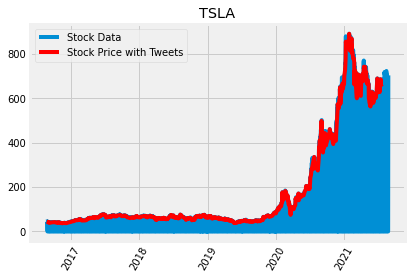

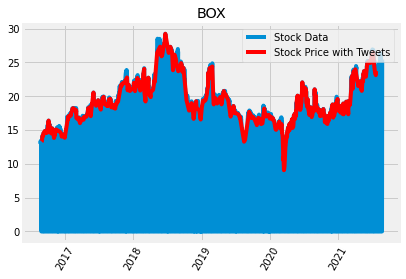

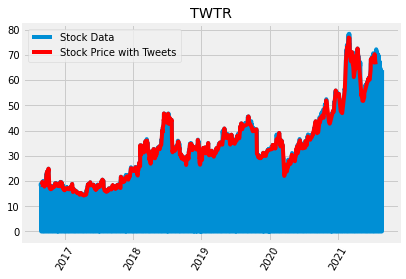

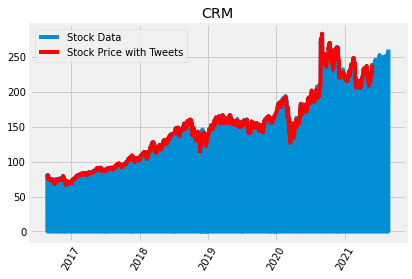

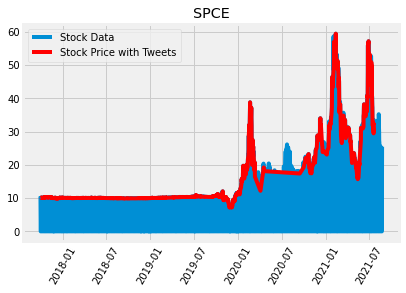

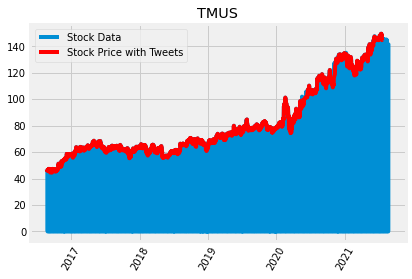

<Figure size 432x288 with 0 Axes>

In [61]:
# Let's look to see how well the full stock prices match the merged tweet and stock DataFrames
for i in range(len(stocks_list)):
    _ = plt.plot(stocks[stocks_list[i]]['date'], stocks[stocks_list[i]]['price'])
    _ = plt.plot(CEOS[CEOS_list[i]]['date'], CEOS[CEOS_list[i]]['price'], c='red')
    _ = plt.title(stocks_list[i])
    _ = plt.xticks(rotation=60)
    _ = plt.legend(['Stock Data', 'Stock Price with Tweets'])
    _ = plt.show()
    plt.savefig('./figures/data_wrangling/Price_Tweets_{}.png'.format(stocks_list[i]), bbox_inches='tight')

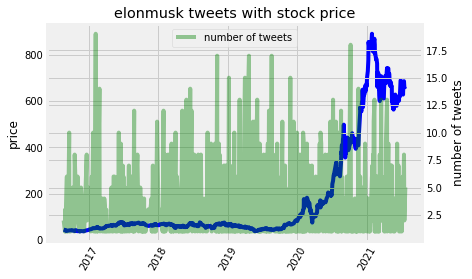

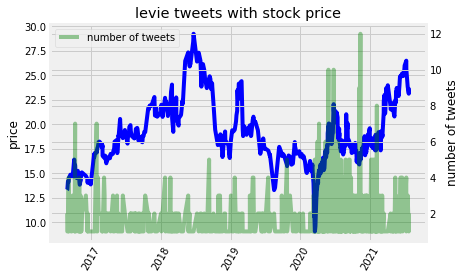

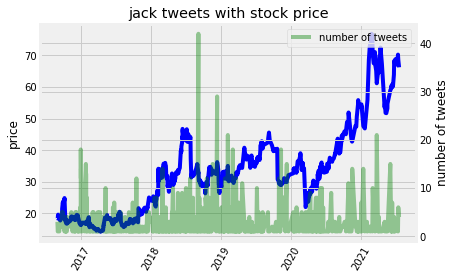

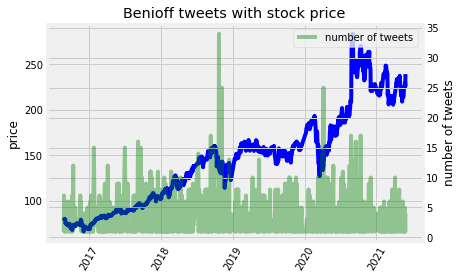

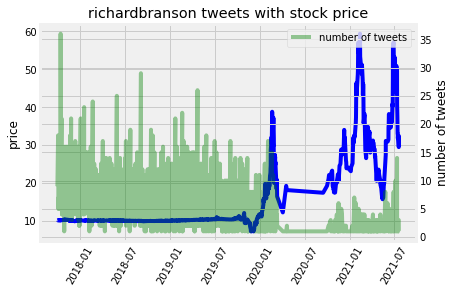

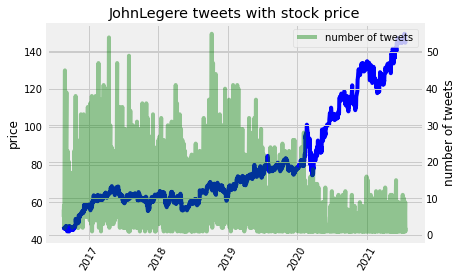

In [62]:
# Initalize a Figure and Axes
for CEO in CEOS:
    fig, ax = plt.subplots()

    ax.plot(CEOS[CEO]['date'], CEOS[CEO]['price'], color='blue')
    plt.ylabel('price')
    plt.title(f'{CEO} tweets with stock price')
    plt.xticks(rotation=60)

    # Create a twin Axes that shares the x-axis
    ax2 = ax.twinx()
    
    ax2.plot(CEOS[CEO]['date'], CEOS[CEO]['number of tweets'], color='g', alpha = 0.4)
    plt.ylabel('number of tweets')
    plt.legend(['number of tweets'])
    plt.savefig('./figures/data_wrangling/num_tweets_stock_price_{}.png'.format(CEO), bbox_inches='tight')
    plt.show()

In [63]:
test = CEOS['JohnLegere']
test2 = CEOS['richardbranson']

In [64]:
test = test[test['date'] <= '2019']
test2 = test2[test2['date'] >= '2020-07']

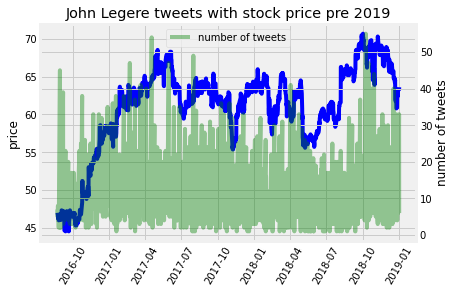

In [65]:
fig, ax = plt.subplots()

ax.plot(test['date'], test['price'], color='blue')
plt.ylabel('price')
plt.title('John Legere tweets with stock price pre 2019')
plt.xticks(rotation=60)

# Create a twin Axes that shares the x-axis
ax2 = ax.twinx()


ax2.plot(test['date'], test['number of tweets'], color='g', alpha = 0.4)
plt.ylabel('number of tweets')
plt.legend(['number of tweets'])
plt.savefig('./figures/data_wrangling/num_tweets_stock_price_JohnLegere_pre2019', bbox_inches='tight')
plt.show()

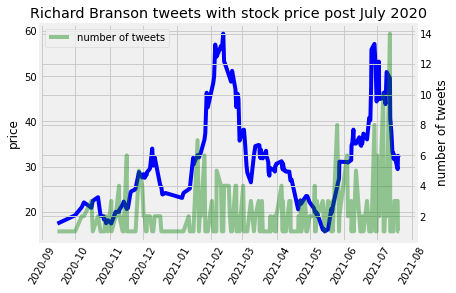

In [66]:
fig, ax = plt.subplots()

ax.plot(test2['date'], test2['price'], color='blue')
plt.ylabel('price')
plt.title('Richard Branson tweets with stock price post July 2020')
plt.xticks(rotation=60)

# Create a twin Axes that shares the x-axis
ax2 = ax.twinx()

ax2.plot(test2['date'], test2['number of tweets'], color='g', alpha = 0.4)
plt.ylabel('number of tweets')
plt.legend(['number of tweets'])
plt.savefig('./figures/data_wrangling/num_tweets_stock_price_richardbranson_post2020', bbox_inches='tight')
plt.show()

## 1.5 Saving Dataframes <a id='1.5_Exporting_DataFrames'></a>

In [67]:
for i in range(len(CEOS_list)):
    CEOS[CEOS_list[i]].to_pickle(f'./data/{CEOS_list[i]}_df.pkl')

In [68]:
tweet_stocks = pd.DataFrame()
for CEO in CEOS:
    tweet_stocks = tweet_stocks.append(CEOS[CEO])

In [69]:
tweet_stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7356 entries, 0 to 2274
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              7356 non-null   datetime64[ns]
 1   tweet             7356 non-null   object        
 2   username          7356 non-null   object        
 3   mentions          7356 non-null   int64         
 4   hashtags          7356 non-null   int64         
 5   video             7356 non-null   int64         
 6   photos            7356 non-null   int64         
 7   urls              7356 non-null   int64         
 8   number of tweets  7356 non-null   int64         
 9   price             7356 non-null   float64       
 10  percent change    7356 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(6), object(2)
memory usage: 689.6+ KB


In [70]:
tweet_stocks.to_pickle(f'./data/tweet_stocks.pkl')

# Data Inspection

In [85]:
ceos.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,search
0,1417453075892080641,1417427520266268677,2021-07-20 07:55:22 EDT,2021-07-20,07:55:22,-0400,44196397,elonmusk,Elon Musk,,...,,,,,"[{'screen_name': 'vincent13031925', 'name': 'V...",,,,,None
1,1417390555001098246,1417251070989029376,2021-07-20 03:46:56 EDT,2021-07-20,03:46:56,-0400,44196397,elonmusk,Elon Musk,,...,,,,,"[{'screen_name': 'blueorigin', 'name': 'Blue O...",,,,,None
2,1417293886897098762,1417278493428264963,2021-07-19 21:22:49 EDT,2021-07-19,21:22:49,-0400,44196397,elonmusk,Elon Musk,,...,,,,,"[{'screen_name': 'SpacePadreIsle', 'name': 'SP...",,,,,None
3,1417277335863140363,1417277092090191884,2021-07-19 20:17:03 EDT,2021-07-19,20:17:03,-0400,44196397,elonmusk,Elon Musk,,...,,,,,"[{'screen_name': 'TLPN_Official', 'name': 'The...",,,,,None
4,1417274819461095432,1417274819461095432,2021-07-19 20:07:03 EDT,2021-07-19,20:07:03,-0400,44196397,elonmusk,Elon Musk,,...,,,,,[],,,,,None


In [ ]:
# Correct the data types

